In [1]:
import matplotlib.pyplot as plt

from IPython.display import display

from tqdm import tqdm_notebook

import math
import numpy as np
import time

from PIL import Image

import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision.transforms as transforms

from warpctc_pytorch import CTCLoss

from lib.utilities import HYPERPARAMETERS, Metric, torch_weight_init, print_model_summary, DelayedKeyboardInterrupt, \
    plot_learning_curves, visualize_data, SequenceWise
from lib.vocabulary import Vocabulary
from lib.dataloader import DataArgumentation, FromNumpyToTensor, IAMHandwritingDataset, alignCollate, ResizeAndPad
from lib.checkpoint import Checkpoint
from lib.model_crnn import CRNN
from lib.decoder import CTCGreedyDecoder
from lib.stopping import Stopping
from lib.logger import PytorchLogger, TensorboardLogger
from lib.spelling import Spelling
from lib.trainer import Trainer
from lib.evaluator import Evaluator
from lib.recognizer import Recognizer
from lib.scorer import Scorer, SpellingScorer, ScorerSM, ScorerLEV

In [2]:
#torch.cuda.is_available = lambda : False
#torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = True

In [3]:
seed = 0
np.random.seed(0)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [4]:
H = HYPERPARAMETERS({
    'MODEL_PATH': './chkpt/IAM_HTR_CTC08.tar',
    'ROOT_DIR': './data',
    'EXPERIMENT': 'IAM_HTR_CTC08',
    'BATCH_SIZE': 16,
    'HEIGHT': 64,
    'PADDING': 10,
    'NUM_WORKERS': 8,
    'HIDDEN_SIZE': 256,
    'NUM_LAYERS': 2,
    'RNN_DROPOUT': 0.5,
    'LR': 0.0003,
    'LR_LAMBDA': lambda epoch: max(math.pow(0.78, math.floor((1 + epoch) / 11.0)), 0.4),
    'WEIGHT_DECAY': 0,
    'MAX_GRAD_NORM': 5.,
    'ARGUMENTATION': 0.9,
    'STOPPING_PATIENCE': 10,
    'NUM_EPOCHS': 20,
    
    'CHECKPOINT_FILE': 'IAM_HTR_CTC08',
    'CHECKPOINT_INTERVAL': 5,
    'CHECKPOINT_RESTORE': False,
    
    'USE_CUDA': torch.cuda.is_available(),
})

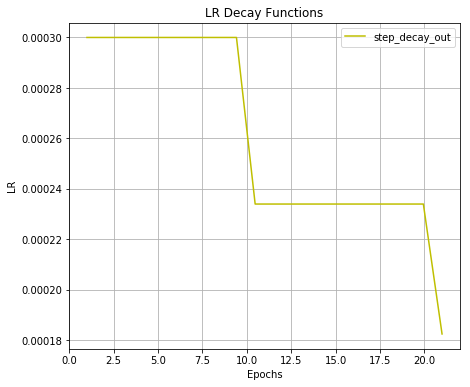

In [5]:
#https://research.fb.com/wp-content/uploads/2017/06/imagenet1kin1h5.pdf?

max_epochs = H.NUM_EPOCHS
epts = np.linspace(1, max_epochs+1, max_epochs)
step_decay_out = np.vectorize(H.LR_LAMBDA)(epts) * H.LR

plt.figure(figsize=(7,6))
plt.plot(epts,step_decay_out, label='step_decay_out', color='y')
plt.title("LR Decay Functions")
plt.xlabel("Epochs");
plt.ylabel("LR");
plt.grid(True)
plt.legend(loc='upper right');

In [6]:
# # IAMHandwritingDataset.create('./data/IAM/')
# vocab = Vocabulary("./data/IAM/")
# train_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="train")
# len(train_dataset.annotations[0]['transcript'])
# train_dataset.annotations[0]['transcript']
# d = {}
# for ann in train_dataset.annotations:
#     for c in ann['transcript']:
#         d[c] = 1 if not c in d else d[c] + 1
# vocab.create(sorted(list(d.keys())))
# vocab.dump()

In [7]:
import os
import json

class Vocabulary(object):
    def __init__(self, root_dir, structure='lines', architecture="ctc"):
        self.root_dir = root_dir
        self.structure = structure         # 'lines', 'words'
        self.architecture = architecture   # 'ctc', 'seq'

        self.token2idx = {}
        self.idx2token = {}
        self.idx = 0
        self.path = os.path.join(self.root_dir, 'vocab_'+ self.structure + '.json')

        if self.architecture == 'ctc':
            self.add(chr(1)) # extra output dimension for the BLANK label required for CTC loss
        else:
            self.add(chr(0)) 
            
    def add(self, token):
        if not token in self.token2idx:
            self.token2idx[token] = self.idx
            self.idx2token[self.idx] = token
            self.idx += 1

    def __call__(self, val):
        res = None
        if isinstance(val, str):
            res = self.token2idx[val] if val in self.token2idx else self.token2idx['']
        elif isinstance(val, int):
            res = self.idx2token[val] if val <= self.__len__() else self.token2idx['']
        else:
            raise RuntimeError
        return res

    def __len__(self):
        return len(self.token2idx)

    def create(self, alphabet):
        for c in alphabet:
            self.add(c)

    def dump(self):
        data = {'idx': self.idx, 'token2idx':self.token2idx, 'idx2token':self.idx2token}
        with open(self.path, "w") as fd:
            json.dump(data, fd)

    def load(self):
        with open(self.path, "r") as fd:
            data = json.load(fd)
            self.idx = int(data['idx'])
            self.token2idx = data['token2idx']
            self.idx2token = {int(k):v for k,v in data['idx2token'].items()}
            
        if self.architecture == 'seq':
            self.add('<SOS>')
            self.add('<EOS>')
            self.add('<UNK>')

    def __repr__(self):
        return ''.join(list(self.token2idx.keys()))

In [8]:
vocab = Vocabulary("./data/IAM/")
vocab.load()
vocab, len(vocab)

(  !"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz,
 80)

In [9]:
# class DataArgumentation(object):
#     def __init__(self, threshold=0.5):
#         self.threshold = threshold

#     def __call__(self, img):
#         if random.random() < self.threshold:
#             img = np.array(img)
#             img = img.reshape(1, img.shape[0], img.shape[1])

# #             img = prepro.rotation(img, 5, is_random=True, row_index=1, col_index=2, channel_index=0)
#             img = prepro.shift(img, 0.01, 0.04, is_random=True, row_index=1, col_index=2, channel_index=0)
# #             img = prepro.shear(img, intensity=0.1, is_random=True, row_index=1, col_index=2, channel_index=0)
# #             img = prepro.zoom(img, (1.0, 1.2), is_random=True, row_index=1, col_index=2, channel_index=0)

#             img = prepro.elastic_transform(img.squeeze(0), is_random=True, alpha=5.5, sigma=35, cval=0.0)

#             img = Image.fromarray(img)
#         return img

In [10]:
import os
from glob import glob
from os.path import basename

import json
import random
import numpy as np
import re
import math

import PIL
from PIL import Image

import torch
import torch.utils.data as data
import torchvision.transforms as transforms

import tensorlayer.prepro as prepro

class IAMHandwritingDataset(data.Dataset):
    """IAM Handwriting Database ( http://www.fki.inf.unibe.ch/databases/iam-handwriting-database )"""

    def __init__(self, root, vocab, dataset, structure, 
                 transform=None, target_transform=None, max_size=None):
        self.root = root
        self.vocab = vocab
        self.dataset = dataset
        self.structure = structure         # 'lines', 'words'
        self.transform = transform
        self.target_transform = target_transform
        self.max_size = max_size


        self.annotations = []
        self.max_seq_length = 0
        self.index = []

        self.annotations, self.max_seq_length = self.load_annotations(self.root, self.dataset, 
                                                                      self.structure)
        self.index = self.load_index(self.root, structure)

        if isinstance(self.max_size, int):

            assert self.max_size < len(self.annotations) # max_train_size needs to select a subset

            self.annotations = random.sample(self.annotations, self.max_size)

    def __getitem__(self, index):
        annotation = self.annotations[index]
        anid = annotation['anid']
        path = self.index[anid]

        image = Image.open(path).convert('L')
        if self.transform is not None:
            image = self.transform(image)

        target = annotation['transcript']
        if vocab.architecture == 'seq':
            target = [self.vocab("<SOS>")] + [self.vocab(token) for token in target] + [self.vocab('<EOS>')]
        else:
            target = [self.vocab(token) for token in target]
        target = np.array(target)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.annotations)

    @classmethod
    def create(cls, root, structure='lines', partition='aachen'):
        path = os.path.join(root, 'part', structure, partition, 'tr.txt')
        with open(path, 'r') as infile:
            trainset = {v.strip() for v in infile.readlines()}

        try:
            path = os.path.join(root, 'part', structure, partition, 'va.txt')
            with open(path , 'r') as infile:
                validationset1 = {v.strip() for v in infile.readlines()}
                validationset2 = {}
        except:
            try:
                path = os.path.join(root, 'part', structure, partition, 'va1.txt')
                with open(path , 'r') as infile:
                    validationset1 = {v.strip() for v in infile.readlines()}
                
                path = os.path.join(root, 'part', structure, partition, 'va2.txt')
                with open(path, 'r') as infile:
                    validationset2 = {v.strip() for v in infile.readlines()}
            except:
                raise RuntimeError('Dataset files not found.')

        path = os.path.join(root, 'part', structure, partition, 'te.txt')
        with open(path, 'r') as infile:
            testset = {v.strip() for v in infile.readlines()}
            
        file_index = cls.load_index(root, structure)

        path = os.path.join(root, 'ascii', structure + '.txt')

        annotations = []
        max_seq_length = 0
        with open(path, "r") as fd:
            for idx, line in enumerate(fd.readlines()):
                if '#' in line[0]:
                    continue
                fields = line.rstrip().split(" ")

                transcript = fields[8]
                # transcript field has whitespaces in it - need to fix the erroneous splits
                if len(fields) > 9:
                    for i in range(9, len(fields)):
                        transcript += fields[i]

                if structure == 'lines':
                    # replace | seperator with whitespace
                    transcript = transcript.replace("|", " ")

                l = len(transcript)
                if not l:
                    continue

                if l > max_seq_length:
                    max_seq_length = l

                if structure == 'lines':
                    annotation={
                        'anid': fields[0],
                        'seg_result': fields[1],
                        'graylevel': fields[2],
                        'components': fields[3],
                        'bounding_box':[fields[4], fields[5], fields[6], fields[7]],
                        'transcript': transcript
                    }
                else:
                    annotation={
                        'anid': fields[0],
                        'seg_result': fields[1],
                        'graylevel': fields[2],
                        'bounding_box':[fields[3], fields[4], fields[5], fields[6]],
                        'tag': fields[7],
                        'transcript': transcript
                    }
                    
                anid = annotation['anid']
                
                try:
                    path = file_index[anid]
                    _ = Image.open(path)
                except (IOError, KeyError):
                    print('Corrupted image for %s ' % path)
                    continue

                if not anid in file_index:
                    print('File missing %s' % path)
                    continue

                if structure == 'words':                                
                    anid = annotation['anid'][:-3]
                    
                if anid in trainset:
                    dataset = "train"
                elif anid in validationset1:
                    dataset = "valid1"
                elif anid in validationset2:
                    dataset = "valid2"
                elif anid in testset:
                    dataset = "test"
                else:
                    dataset = "train"
                
                annotation['dataset'] = dataset

                annotations.append(annotation)

        path = os.path.join(root, 'annotations_'+ structure + '.json')

        with open(path, 'w') as outfile:
            json.dump({'annotations': annotations,
                       'max_seq_length': max_seq_length},
                      outfile)

    @classmethod
    def load_annotations(cls, root, dataset, structure):
        path = os.path.join(root, 'annotations_'+ structure + '.json')

        with open(path, "r") as fd:
            content = json.load(fd)

        if not len(content):
            raise RuntimeError('Dataset empty.')

        annotations = content['annotations']
        max_seq_length = content['max_seq_length']

        if "train" in dataset:
            annotations = [a for a in annotations if 'train' in a['dataset']]
        elif "valid" in dataset:
            annotations = [a for a in annotations if 'valid1' in a['dataset'] or 'valid2' in a['dataset']]
        elif "test" in dataset:
            annotations = [a for a in annotations if 'test' in a['dataset']]
        else:
            raise RuntimeError('Dataset parameter can be: "train", "valid" or "test".')

        return annotations, max_seq_length

    @classmethod
    def load_index(cls, root, structure):
        extension = 'jpg' #if 'lines' in structure else '.png'
        path = os.path.join(root, 'imgs', structure)
                
        files = []
        for root, dirs, flst in os.walk(path):
            for file in flst:
                if file.endswith(extension):
                    files.append(os.path.join(root, file))

        index = dict([(basename(path).rstrip("." + extension) , path) for path in files])

        if not len(index):
            raise RuntimeError('Image files empty.')
        return index

    def __repr__(self):
        fmt_str = self.__class__.__name__ + '\n'
        fmt_str += '    Number of images found: {}\n'.format(len(self.index))
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str
    

In [11]:
image_transform_train = transforms.Compose([
    transforms.Pad((H.PADDING, H.PADDING, H.PADDING, H.PADDING), fill=255),
#     DataArgumentation(threshold=H.ARGUMENTATION),
    transforms.ToTensor(),
])

image_transform_test = transforms.Compose([
    transforms.Pad((H.PADDING, H.PADDING, H.PADDING, H.PADDING), fill=255),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    FromNumpyToTensor()
])

In [12]:
train_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="train", structure="lines", #max_size=10000,
                                     transform=image_transform_train, target_transform=target_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=H.BATCH_SIZE, num_workers=H.NUM_WORKERS, shuffle=True,
    collate_fn=alignCollate(img_height=H.HEIGHT), pin_memory=True)

train_dataset, len(train_loader)

(IAMHandwritingDataset
     Number of images found: 13353
     Number of datapoints: 9472
     Root Location: ./data/IAM/
     Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1bb416c18>
     Target Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1bb4160f0>,
 592)

In [13]:
valid_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="valid", structure="lines", #max_size=200,
                                     transform=image_transform_test, target_transform=target_transform)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=H.BATCH_SIZE, shuffle=False, num_workers=H.NUM_WORKERS, 
    collate_fn=alignCollate(img_height=H.HEIGHT), pin_memory=True)

valid_dataset, len(valid_loader)

(IAMHandwritingDataset
     Number of images found: 13353
     Number of datapoints: 966
     Root Location: ./data/IAM/
     Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1bb4167f0>
     Target Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1bb4160f0>,
 61)

In [14]:
test_dataset = IAMHandwritingDataset('./data/IAM/', vocab, dataset="test", structure="lines",
                                     transform=image_transform_test, target_transform=target_transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=H.BATCH_SIZE, shuffle=False, num_workers=H.NUM_WORKERS,
    collate_fn=alignCollate(img_height=H.HEIGHT))

test_dataset, len(test_loader)

(IAMHandwritingDataset
     Number of images found: 13353
     Number of datapoints: 2915
     Root Location: ./data/IAM/
     Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1bb4167f0>
     Target Transforms (if any): <torchvision.transforms.transforms.Compose object at 0x1bb4160f0>,
 183)

In [15]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

input_vars, target_vars, input_sizes, target_len = next(train_loader.__iter__())

print(input_vars.shape, target_vars.shape)

@interact(idx=(0, H['BATCH_SIZE']-1))
def show(idx):
    print(input_vars[idx].shape)
    visualize_data(input_vars[idx], target_vars[idx], vocab)

torch.Size([16, 1, 64, 1259]) torch.Size([16, 63])


interactive(children=(IntSlider(value=7, description='idx', max=15), Output()), _dom_classes=('widget-interact',))

In [16]:
target_vars

tensor([[55, 58,  1,  ...,  0,  0,  0],
        [36, 59,  1,  ..., 54, 67, 57],
        [66, 58, 54,  ...,  0,  0,  0],
        ...,
        [48, 67, 62,  ...,  0,  0,  0],
        [31, 42, 41,  ...,  0,  0,  0],
        [72, 74, 57,  ...,  0,  0,  0]])

In [17]:
m = Metric([('train_loss', np.inf), ('train_score', np.inf), ('valid_loss', np.inf), ('valid_score', 0), 
            ('train_lr', 0), ('valid_cer', np.inf)])

crnn = CRNN(num_classes=len(vocab), hidden_size=H.HIDDEN_SIZE, num_layers=H.NUM_LAYERS, rnn_dropout=H.RNN_DROPOUT,
            initialize=torch_weight_init)
if H.USE_CUDA:
    crnn.cuda()

optimizer = optim.Adam(list(filter(lambda p:p.requires_grad, crnn.parameters())),
                       amsgrad = False,
                       betas = (0.9, 0.999),
                       eps = 1e-08,
                       lr = H.LR,
                       weight_decay = H.WEIGHT_DECAY)

criterion = CTCLoss()

stopping = Stopping(crnn, patience= H.STOPPING_PATIENCE)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[H.LR_LAMBDA])

decoder = CTCGreedyDecoder(vocab)

logger = TensorboardLogger(experiment_dir=H.EXPERIMENT) #PytorchLogger()

checkpoint = Checkpoint(crnn, optimizer, stopping, m, experiment_dir=H.EXPERIMENT, checkpoint_file=H.CHECKPOINT_FILE,
                         restore_from=-1, interval=H.CHECKPOINT_INTERVAL, verbose=0)

scorer = ScorerSM()

trainer = Trainer(crnn, train_loader, optimizer, scheduler, criterion, decoder)

train_evaluator = Evaluator(crnn, valid_loader, criterion, decoder, scorer)

In [18]:
vocab.token2idx.keys()

dict_keys(['\x00', ' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])

In [19]:
%%time
epoch_start = checkpoint.restore()+1 if H.CHECKPOINT_RESTORE else 1

epoch_itr = logger.set_itr(range(epoch_start, H.NUM_EPOCHS+1))

epoch = 0
for epoch in epoch_itr:

    with DelayedKeyboardInterrupt():

        m.train_loss, m.train_lr = trainer.train(epoch, H.MAX_GRAD_NORM)
        
        m.valid_loss, m.valid_score, m.valid_cer = train_evaluator.evaluate()                               
            
        epoch_itr.log_values( m.train_loss, m.train_score, m.train_lr, m.valid_loss, m.valid_score,
                              stopping.best_score_epoch, stopping.best_score)
        
        if checkpoint:
            checkpoint.step(epoch)
            
        if stopping.step(epoch, 0, m.valid_score):
            print("Early stopping at epoch: %d, score %f" % (stopping.best_score_epoch, stopping.best_score))
            break
            
checkpoint.create(epoch)

CPU times: user 1h 38min 16s, sys: 1min 5s, total: 1h 39min 21s
Wall time: 1h 38min 12s


{'ARGUMENTATION': 0.9,
 'BATCH_SIZE': 16,
 'CHECKPOINT_FILE': 'IAM_HTR_CTC08',
 'CHECKPOINT_INTERVAL': 5,
 'CHECKPOINT_RESTORE': False,
 'EXPERIMENT': 'IAM_HTR_CTC08',
 'HEIGHT': 64,
 'HIDDEN_SIZE': 256,
 'LR': 0.0003,
 'LR_LAMBDA': <function __main__.<lambda>>,
 'MAX_GRAD_NORM': 5.0,
 'MODEL_PATH': './chkpt/IAM_HTR_CTC08.tar',
 'NUM_EPOCHS': 20,
 'NUM_LAYERS': 2,
 'NUM_WORKERS': 8,
 'PADDING': 10,
 'RNN_DROPOUT': 0.5,
 'ROOT_DIR': './data',
 'STOPPING_PATIENCE': 10,
 'USE_CUDA': True,
 'WEIGHT_DECAY': 0}

TensorboardLogger
    Last Epoch/LR:    20 / 0.000234
    Train Loss/Score: 8.890155523612693 / inf
    Valid Loss/Score: 9.35405035683366 / 0.9572857934714726
    Best Epoch/Score: 18 / 0.9566100093689708

Stopping
    Patience: 10
    Best Score: 0.9573
    Epoch of Best Score: 20

Checkpoint
    Timestamp: 2019_02_05_16_54_46
    Last Checkpoint: chkpt/IAM_HTR_CTC08/2019_02_05_16_54_46/state.tar



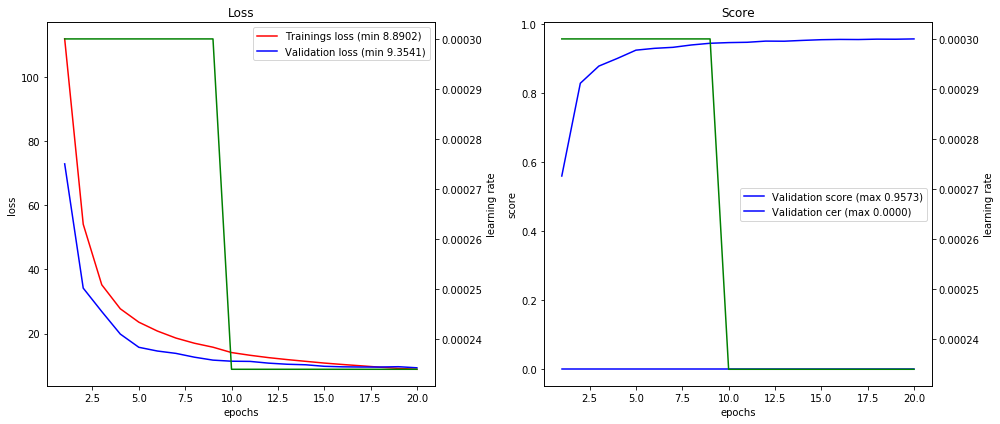

In [20]:
display(H)
print(logger)
print(stopping)
print(checkpoint)
plot_learning_curves(m)

In [21]:
crnn.load_state_dict(stopping.best_score_state)
torch.save(crnn.state_dict(), H.MODEL_PATH)

In [22]:
from nltk.translate.bleu_score import sentence_bleu
import Levenshtein as lev

class Scorer(object):
    def __init__(self):
        pass
    
    @staticmethod
    def wer(s1, s2):
        b = set(s1.split() + s2.split())
        word2char = dict(zip(b, range(len(b))))

        w1 = [chr(word2char[w]) for w in s1.split()]
        w2 = [chr(word2char[w]) for w in s2.split()]
        return lev.distance(''.join(w1), ''.join(w2)) 

    @staticmethod
    def cer(s1, s2):
        s1, s2, = s1.replace(' ', ''), s2.replace(' ', '')
        return lev.distance(s1, s2) 
    
    def score(self,predicted_vars, target_vars):
        idx, acc, cer = 0, 0.0, 0.0
        for idx, (dseq, tseq) in enumerate(zip(predicted_vars, target_vars)):
#           acc = acc + 1 if dseq == tseq else acc
#             acc += fuzz.ratio(tseq, dseq)
#             acc += SequenceMatcher(None, dseq, tseq).ratio()
#             acc += sentence_bleu([tseq], dseq, emulate_multibleu=True)
            acc += self.wer(dseq, tseq) / float(len(tseq.split()))
            cer += self.cer(dseq, tseq) / float(len(tseq))

        return (acc / (idx + 1)), cer / (idx + 1)
    
scorer = Scorer()

In [23]:
crnn_pred = CRNN(num_classes=len(vocab), hidden_size=H.HIDDEN_SIZE, num_layers=H.NUM_LAYERS, rnn_dropout=H.RNN_DROPOUT,
                 initialize=torch_weight_init)
if H.USE_CUDA:
    crnn_pred.cuda()

state = torch.load(H.MODEL_PATH)
crnn_pred.load_state_dict(state)

In [24]:
%%time
decoder = CTCGreedyDecoder(vocab)

test_evaluator = Evaluator(crnn_pred, test_loader, criterion, decoder, scorer)

avg_loss, avg_score, avg_cer = test_evaluator.evaluate()

print('Test Results:')
print('     Loss:           {:.4f}'.format(avg_loss))
print('     Accuracy:       {:.4f}'.format(avg_score))
print('     CER:            {:.4f}'.format(avg_cer))

Test Results:
     Loss:           16.3392
     Accuracy:       0.2523
     CER:            0.0703
CPU times: user 24.3 s, sys: 538 ms, total: 24.9 s
Wall time: 25 s


In [28]:
crnn_pred.eval()
with torch.no_grad():
    idx_batch = 0
    bad_lines = []
    for idx_batch,(input_vars, target_vars, input_size, target_size) in enumerate(test_loader):
        input_vars = Variable(input_vars)
        if H.USE_CUDA:
            input_vars = input_vars.cuda()

        preds = crnn_pred(input_vars)
        preds = preds.transpose(1,0)
        preds_size = torch.IntTensor(preds.size(1)).fill_(preds.size(0))

        decoder_seq, target_seq = decoder(preds, target_vars, preds_size, target_size)

        for idx, (dseq, tseq) in enumerate(zip(decoder_seq, target_seq)):
            if dseq != tseq:
                bad_lines.append((input_vars[idx], dseq, tseq))
                    
len(bad_lines)

2335

92 5


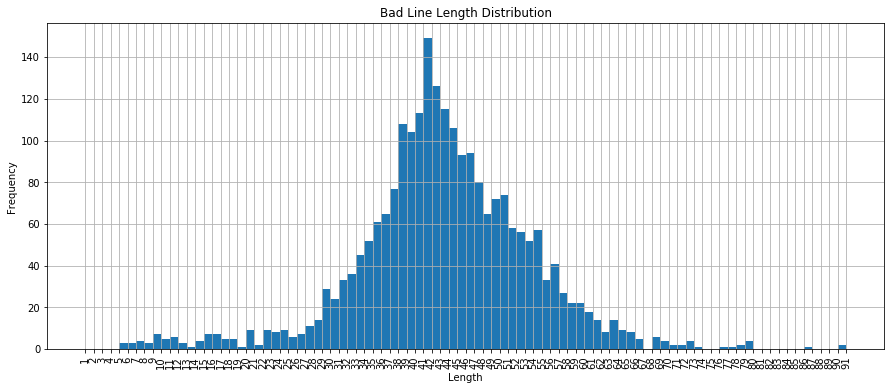

In [29]:
import matplotlib.mlab as mlab

line_len = sorted([len(l[1]) for l in bad_lines], reverse=True)
print(max(line_len), min(line_len))

if max(line_len):
    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xticks(range(1, max(line_len)))

    ax = plt.hist(line_len, bins=range(1, max(line_len)))

    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.title("Bad Line Length Distribution")
    plt.xticks(rotation=90)
    plt.grid(True)

In [30]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(idx=(0, len(bad_lines)))
def show(idx):
    img = bad_lines[idx][0]
    dseq = bad_lines[idx][1]
    tseq = bad_lines[idx][2]
    visualize_data(img, tseq + "==" + dseq + "=" + str(tseq==dseq), vocab, figsize=(18,8))

interactive(children=(IntSlider(value=1167, description='idx', max=2335), Output()), _dom_classes=('widget-interact',))